In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms import v2
from torchvision import transforms, models

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
df_total_train = pd.read_csv('./eda/df_total_train.csv')
df_total_val = pd.read_csv('./eda/df_total_val.csv')
df_total_test = pd.read_csv('./eda/df_total_test.csv')

In [3]:
train_X = (df_total_train['img_folder'] + df_total_train['defect_image']).tolist()
train_y = (df_total_train['repairStatus']).tolist()

val_X = (df_total_val['img_folder'] + df_total_val['defect_image']).tolist()
val_y = (df_total_val['repairStatus']).tolist()

test_X = (df_total_test['img_folder'] + df_total_test['defect_image']).tolist()
test_y = (df_total_test['repairStatus']).tolist()

In [4]:
class image(Dataset):

    def __init__(self, X, Y, transform=None):
        self.X = X
        self.y = Y
        self.transform = transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
 
        img_path = self.X[idx]
        image = read_image(img_path)

        if image.size()[0] == 1:
            image = image.expand(3,*image.shape[1:])

        if self.transform:
            image = self.transform(image)

        return image, self.y[idx]

In [5]:
resolution = (240, 240)

train_transforms = transforms.Compose([
    transforms.Resize(resolution),
    # transforms.RandomHorizontalFlip(),
    # v2.RandomCrop(size=(224, 224)),
    # v2.RandomResizedCrop(size=(32, 32)),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    # v2.equalizer = v2.RandomEqualize(),
    # v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
    # transforms.ColorJitter(),
    # transforms.ToTensor(),
    # transforms.RandAugment(num_ops = 2, magnitude = 9),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    # transforms.RandomErasing(),
])

val_transforms = transforms.Compose([
    transforms.Resize(resolution),
    #transforms.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.Resize(resolution),
    #transforms.ToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = image(train_X, train_y, train_transforms)
val_dataset = image(val_X, val_y, val_transforms)
test_dataset = image(test_X, test_y, test_transforms)

batch_size = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

/home/ilya/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


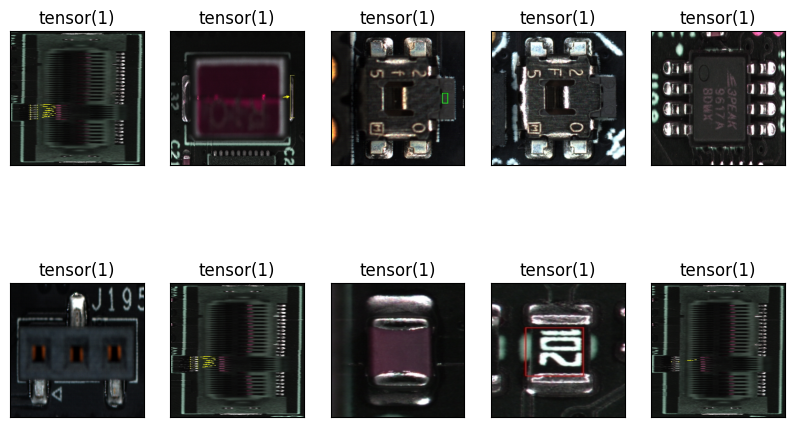

In [6]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

img = images.numpy()
img = img / 2 + 0.5

fig, axes = plt.subplots(2, int(batch_size/2), figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(np.transpose(img[i], (1, 2, 0)))
    ax.set_title(labels[i])

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
device

NVIDIA GeForce RTX 3060 Ti


device(type='cuda', index=0)

In [12]:
def train_model(model, loss, optimizer, num_epochs, device):
    '''
        Обучение модели
    '''
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # на каждой эпохе проходим фазу обучения и валидации
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train() # обучение
            else:
                dataloader = val_dataloader
                model.eval() # валидация

            # метрики потерь и точности
            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):

                    # forward
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    
                    # backward в фазе обучения
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                
                # обновление метрик
                running_loss += loss_value.item()
                if phase == 'train':
                    # running_acc += (preds_class == labels.argmax(dim=1)).float().mean()
                    running_acc += (preds_class == labels).float().mean()
                else:
                    running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
        
    # return model

In [9]:
# предобученная модель efficientnet_v2_l
model = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT')

# перекладываем модель на device (если есть gpu)
model = model.to(device)

# функция потерь
loss = torch.nn.CrossEntropyLoss()
# оптимизатор
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0.00001, verbose=True)

num_epochs = 1

In [10]:
train_model(model, loss, optimizer, num_epochs=num_epochs, device=device)

Epoch 0/0:


100%|██████████| 4911/4911 [36:09<00:00,  2.26it/s]

train Loss: 0.0440 Acc: 0.9924



100%|██████████| 655/655 [03:09<00:00,  3.47it/s]

val Loss: 0.0448 Acc: 0.9833


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [11]:
torch.save(model, "./EfV2L_noaug_1e_base_v1.pt")

In [13]:
# загружаем модель
model_path = '.'
model = torch.load(f'{model_path}/EfV2L_noaug_1e_base_v1.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [15]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        preds = model(inputs)
        loss_value = loss(preds, labels)
        preds_class = preds.argmax(dim=1)

        total += labels.size(0)
        correct += (preds_class == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')

100%|██████████| 982/982 [03:57<00:00,  4.13it/s]

Accuracy of the network on the 9820 test images: 98.9918533604888 %
